Este Notebook fue construido en Colab

# Proyecto final Deep Learning - Clasificación de imágenes

Integrantes:

* [Ángela Patricia Ordoñez C.](ap.ordonez@uniandes.edu.co).......................... Código: 201628709
* [Juan Sebastián Garcés C.](js.garcesc@uniandes.edu.co)............................ Código: 210628949


In [1]:
# Para la utenticación al Drive de Google:
!pip install -U -q PyDrive

import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Listar los elementos dentro de la carpeta de Drive
file_list = drive.ListFile({'q': "'1B8WZPM0zEwAdG-RA---21-lsjN3UHH3N' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Clasificación Imagenes, id: 1gyfsAz2DiiRxDUcuHNzwMQSQUB7OFRgg
title: Clasificación texto proyecto final.ipynb, id: 1nGQfq6pwuvdE8j7_R8iYnLbqkyfd9_gm
title: ExampleImgRF.ipynb, id: 1wmEzI2o6A5moDIjUT459-g6BkDMYra4P
title: New2.zip, id: 146bCbiCFvaLYTgJttSDOMSx_ZpSykuec
title: New1.zip, id: 1WD7dpPnXBXt94VMttpVjyJuGhZDrOtUt
title: Resize.py, id: 1KrJMOR1VX5Y3QShfpiXSWJsDhL9Xvqmt
title: moviegenre.png, id: 1dzzYpftTXRtriaQXvmp3eLX83rYdh1DZ
title: images_resize_gray.zip, id: 1vviR_p9sAEWGO4ImcwwmFmIcMVKRQDKR
title: Data, id: 1HYCj7itIenMHw_RTlmHhf9Oj1cpPoUho
title: ExampleTextRF.ipynb, id: 1UW9zq4Gi3k9drFZqziEQHZAo3GSUTOn4


En la carpeta 'New.zip' se encuentran las imágenes insumo para construir los modelos (Esta carpeta contiene las imágenes con una modificación del tamaño, aquellas cuyo ancho fuera mayor a 300 pixeles fueron reducidas a 300 pixeles, las demás se dejaron del tamaño original, ver el archivo [Resize.py](https://drive.google.com/file/d/1KrJMOR1VX5Y3QShfpiXSWJsDhL9Xvqmt/view?usp=sharing)):

In [0]:
# Carga la carpeta a la carpeta temporal de Colab
file_id = '146bCbiCFvaLYTgJttSDOMSx_ZpSykuec'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [0]:
# Descomprimir la carpeta
!unzip -o New2.zip > /dev/null

In [5]:
# Lista los elementos que están cargados en Colab
!ls

datalab		 dataTraining.csv  New2      pred_genres_colimg_RF.csv
dataTesting.csv  __MACOSX	   New2.zip  pred_genres_img_TL.csv


Para probar si la carpeta ha sido cargada correctamente, se muestra la primera imagen:

Using TensorFlow backend.


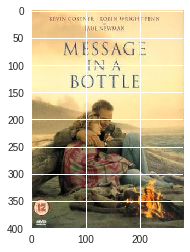

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('New2/1.jpeg')  # this is a PIL image
x = img_to_array(img)
plt.imshow(img)

In [7]:
x.shape

(400, 280, 3)

In [8]:
# Para obtener el ID de las bases
file_list = drive.ListFile({'q': "'1HYCj7itIenMHw_RTlmHhf9Oj1cpPoUho' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: dataTesting.csv, id: 1KWPp9AiZ28adE_mg8GRs4vYvgn8Frz9T
title: dataTraining.csv, id: 1tbl0cOjQ2RjgDNbqBl_J906gF84L3GWX


In [9]:
!pip install tqdm

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Cargar a colab, las bases de datos para identificar Train y Test
train_downloaded = drive.CreateFile({'id': '1tbl0cOjQ2RjgDNbqBl_J906gF84L3GWX'})
train_downloaded.GetContentFile('dataTraining.csv')
test_downloaded = drive.CreateFile({'id':'1KWPp9AiZ28adE_mg8GRs4vYvgn8Frz9T'})
test_downloaded.GetContentFile('dataTesting.csv')

# Abrir las bases de datos:
import pandas as pd
import numpy as np
dataTraining = pd.read_csv('dataTraining.csv')
dataTesting = pd.read_csv('dataTesting.csv')

In [11]:
import pandas as pd
import numpy as np
dataTraining = pd.read_csv('dataTraining.csv')
dataTesting = pd.read_csv('dataTesting.csv')
dataTesting.head()

,Unnamed: 0,year,title,plot
0,1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
1,4,1978,Midnight Express,"the true story of billy hayes , an american c..."
2,5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
3,6,1950,Crisis,husband and wife americans dr . eugene and mr...
4,7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [12]:
dataTraining.head()

,Unnamed: 0,year,title,plot,genres,rating
0,3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


## Carga de imagenes

Cargar todas las imagenes dependiendo si pertenecen al Train o al Test.

In [13]:
io.imread(os.path.join('New2', str(0) + '.jpeg')).flatten()[1:5]

array([239,  21, 228, 238], dtype=uint8)

In [14]:
# Carga de imagens para el train
sam = np.concatenate((np.arange(0,26000),np.arange(112000,138000),np.arange(224000,250000)),axis=0)
images_training = []
for i in tqdm(dataTraining['Unnamed: 0']):
    images_training.append(io.imread(os.path.join('New2', str(i) + '.jpeg')).flatten()[sam])
    
images_training = np.stack(images_training)
images_training.shape, dataTraining.shape[0]

100%|██████████| 7895/7895 [00:23<00:00, 341.12it/s]


((7895, 78000), 7895)

In [15]:
# Carga de imagens para el test
images_testing = []
for i in tqdm(dataTesting['Unnamed: 0']):
    images_testing.append(io.imread(os.path.join('New2', str(i) + '.jpeg')).flatten()[sam])
    
images_testing = np.stack(images_testing)
images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:09<00:00, 366.23it/s]


((3383, 78000), 3383)

## Apply PCA

In [0]:
pca = PCA(n_components=80)
images_training_pca = pca.fit_transform(images_training)

In [0]:
images_testing_pca = pca.transform(images_testing)

## Create y

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [19]:
y_genres.shape

(7895, 24)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

In [21]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=600, random_state=42))
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [23]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.574753033200102

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting['Unnamed: 0'], columns=cols).to_csv('pred_genres_colimg_RF.csv', index_label='ID')

In [0]:
from google.colab import files
files.download('pred_genres_colimg_RF.csv')

In [0]:
# For stacking
pd.DataFrame(y_pred_genres, columns=cols).to_csv('pred_val_RF.csv', index_label='ID')

from google.colab import files
files.download('pred_val_RF.csv')

# Convolutional neural network Image-Movies

In [26]:
!ls

datalab		 dataTraining.csv  New2      pred_genres_colimg_RF.csv
dataTesting.csv  __MACOSX	   New2.zip  pred_genres_img_TL.csv


In [27]:
# Create a new folder inside colab named 'Imagen'
!cd New2 && mkdir ImageTrain
!cd New2 && mkdir ImageTest
!cd New2 && mkdir ImageVal

mkdir: cannot create directory ‘ImageTrain’: File exists
mkdir: cannot create directory ‘ImageTest’: File exists
mkdir: cannot create directory ‘ImageVal’: File exists


In [28]:
# Crear dos carpeta, una para las imagenes de train y otra para las de test
!cd New2/ImageTrain && mkdir Train
!cd New2/ImageTest && mkdir Test
!cd New2/ImageVal && mkdir Val

mkdir: cannot create directory ‘Train’: File exists
mkdir: cannot create directory ‘Test’: File exists
mkdir: cannot create directory ‘Val’: File exists


In [29]:
!cd New2/ImageTest && mkdir Img
!cd New2/ImageTest/Img && mkdir Test

mkdir: cannot create directory ‘Img’: File exists
mkdir: cannot create directory ‘Test’: File exists


In [30]:
!ls New2/ImageTest/Img

Test


In [31]:
!rm New2/ImageTrain/Train/*
!rm New2/ImageVal/Val/*
!rm New2/ImageTest/Img/Test/*

rm: cannot remove 'New2/ImageTrain/Train/*': No such file or directory
rm: cannot remove 'New2/ImageVal/Val/*': No such file or directory
rm: cannot remove 'New2/ImageTest/Img/Test/*': No such file or directory


Crear un vector para identificar Train y Validation de la base de Training

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataTraining, y_genres, test_size=0.33, random_state=42)

In [33]:
from numpy import random

y_trainCN=[]
y_valCN=[]
# Guardar las imagenes de Train en la carpeta correspondiente
for i in tqdm(X_train['Unnamed: 0']):
   # if random.random() > 0.3:
    os.rename(os.path.join('New2', str(i) + '.jpeg'), os.path.join('New2/ImageTrain/Train', str(i) + '.jpeg'))
    y_trainCN.append(y_genres[np.where(dataTraining['Unnamed: 0']==i)[0].tolist()[0]])
    #else:
for i in tqdm(X_test['Unnamed: 0']):
    os.rename(os.path.join('New2', str(i) + '.jpeg'), os.path.join('New2/ImageVal/Val', str(i) + '.jpeg'))
    y_valCN.append(y_genres[np.where(dataTraining['Unnamed: 0']==i)[0].tolist()[0]])

100%|██████████| 2606/2606 [00:00<00:00, 3569.48it/s]


In [34]:
for i in tqdm(dataTesting['Unnamed: 0']):
     os.rename(os.path.join('New2', str(i) + '.jpeg'), os.path.join('New2/ImageTest/Img/Test', str(i) + '.jpeg'))

100%|██████████| 3383/3383 [00:00<00:00, 21058.42it/s]


In [0]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = 'New2/ImageTrain'
val_data_dir = 'New2/ImageVal'
test_data_dir = 'New2/ImageTest/Img'
nb_train_samples = 7895
nb_validation_samples = 3383
epochs = 2
batch_size = 32

In [0]:
from keras.applications.vgg16 import VGG16

model_vgg16 = VGG16(weights='imagenet', include_top=False)

In [0]:
from keras.models import Model
model1 = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer('block5_pool').output)

In [38]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0)

train_generator = data_generator.flow_from_directory(train_data_dir, target_size=(224, 224), shuffle=False, seed=13,
                                                    class_mode='categorical', batch_size=32)

validation_generator = data_generator.flow_from_directory(val_data_dir, target_size=(224, 224),  shuffle=False, seed=13,
                                                   class_mode='categorical', batch_size=32)


Found 5289 images belonging to 1 classes.
Found 2606 images belonging to 1 classes.


In [0]:
X_datatrain = model1.predict_generator(train_generator)

In [40]:
X_datatrain.shape[1:]

(7, 7, 512)

In [0]:
X_validation = model1.predict_generator(validation_generator)

In [42]:
X_validation.shape

(2606, 7, 7, 512)

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

model2 = Sequential()
model2.add(Flatten(input_shape=X_datatrain.shape[1:]))
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.7))
model2.add(Dense(24, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                12312     
Total params: 26,228,248
Trainable params: 26,228,248
Non-trainable params: 0
________________________________________________________________

In [46]:
model2.fit(np.array(X_datatrain), np.array(y_trainCN),
          epochs=10,
          batch_size=batch_size,
          validation_data=(np.array(X_validation), np.array(y_valCN)))

Train on 5289 samples, validate on 2606 samples
Epoch 1/10
5289/5289 [==============================] - 7s 1ms/step - loss: 7.9025 - acc: 0.2178 - val_loss: 7.5934 - val_acc: 0.1926
Epoch 2/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6835 - acc: 0.2205 - val_loss: 7.5664 - val_acc: 0.1926
Epoch 3/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6331 - acc: 0.2031 - val_loss: 7.5367 - val_acc: 0.1926
Epoch 4/10


5289/5289 [==============================] - 6s 1ms/step - loss: 7.6014 - acc: 0.2078 - val_loss: 7.6390 - val_acc: 0.1926
Epoch 5/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6003 - acc: 0.2002 - val_loss: 7.5802 - val_acc: 0.1926
Epoch 6/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6133 - acc: 0.2029 - val_loss: 7.5062 - val_acc: 0.1926
Epoch 7/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6121 - acc: 0.2014 - val_loss: 7.5294 - val_acc: 0.1926
Epoch 8/10
 352/5289 [>.............................] - ETA: 5s - loss: 7.4515 - acc: 0.2045

5289/5289 [==============================] - 6s 1ms/step - loss: 7.5918 - acc: 0.1998 - val_loss: 7.5718 - val_acc: 0.1926
Epoch 9/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.6236 - acc: 0.2010 - val_loss: 7.5543 - val_acc: 0.1926
Epoch 10/10
5289/5289 [==============================] - 6s 1ms/step - loss: 7.5982 - acc: 0.2002 - val_loss: 7.5421 - val_acc: 0.1926


In [0]:
preds = model2.predict_proba(X_validation)

In [48]:
roc_auc_score(np.array(y_valCN), np.array(preds.tolist()), average='macro')

0.487433200743367

In [49]:
# Para predecir sobre la base de test
test_generator = data_generator.flow_from_directory(test_data_dir, target_size=(224, 224),  shuffle=False, seed=13,
                                                   class_mode='categorical', batch_size=32)

X_test = model1.predict_generator(test_generator)


Found 3383 images belonging to 1 classes.


In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
y_pred_genresTL = model2.predict_proba(X_test)

pd.DataFrame(y_pred_genresTL, index=dataTesting['Unnamed: 0'], columns=cols).to_csv('pred_genres_img_TL.csv', index_label='ID')

from google.colab import files
files.download('pred_genres_img_TL.csv')

In [0]:
# For stacking
pd.DataFrame(preds, index=X_test['Unnamed: 0'], columns=cols).to_csv('pred_val_TL.csv', index_label='ID')

from google.colab import files
files.download('pred_val_TL.csv')

# Fine Tuning

In [78]:
from keras.layers import Dense, GlobalAveragePooling2D

#Cargamos el modelo preentrenado el cual se nombro anteriormente como model1:

base_model = model_vgg16 #cargo VGG16 - Top=False

#Se genera la nueva capa de la Red neuronal. Estos parámetros se ajustaron hasta obtener el numero de capas y las neuronas óptimas 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(24, activation='sigmoid')(x)

#Se define el modelo con las capas del VGG16 como capas de entrada y 
#la red neuronal para entrenamiento y predicción

modelFT = Model(inputs=base_model.input, outputs=predictions)

modelFT.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
#Se bloquean las primeras capas del modelo original
for layer in base_model.layers:
    layer.trainable = False

In [0]:
#Se parametrizan el optimizador y el loss
modelFT.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [81]:
X_trainFT=modelFT.predict_generator(train_generator)
X_valFT=modelFT.predict_generator(validation_generator)
X_testFT=modelFT.predict_generator(test_generator)
X_trainFT.shape

(5512, 24)

In [85]:
train_generator.total_batches_seen

348

In [86]:
modelFT.fit_generator(train_generator, epochs=10)

Epoch 1/10


ValueError: ignored

In [84]:
modelFT.fit_generator(np.array(X_trainFT), np.array(y_trainCN),
                      epochs=10,
                      validation_data=(np.array(X_valFT), np.array(y_valCN)))

ValueError: ignored

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
y_pred_genresTL = model2.predict_proba(X_validation)

pd.DataFrame(y_pred_genresTL, index=dataTesting['Unnamed: 0'], columns=cols).to_csv('pred_genres_img_TF.csv', index_label='ID')

from google.colab import files
files.download('pred_genres_img_TF.csv')

## DenseNet 201

In [0]:
X_train3=model_DN201.predict_generator(train_generator)
X_val3=model_DN201.predict_generator(validation_generator)
X_test3=model_DN201.predict_generator(test_generator)
X_train3.shape

In [0]:
model4 = Sequential()

model4.add(Flatten(input_shape=([1,1,1920])))
#model4.add(Dense(units=2048, activation='softmax', input_shape=[0,0,2048]))
model4.add(Dropout(0.5))
model4.add(Dense(24, activation='sigmoid'))

In [0]:
model4.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [0]:
model4.fit(np.array(X_train3), np.array(y_trainCN),
                epochs=10,
                batch_size=batch_size,
                validation_data=(np.array(X_val3), np.array(y_valCN)))

In [0]:
y_pred_DN201 = model_DN201.predict_proba(X_val3)

NameError: ignored